In [1]:
using Luxor

Initialize the atomic coordinates, neighbors, bonds

In [2]:
function init_coordinates!(xs::Array{Float64,2}, 
                           ys::Array{Float64,2}, w::Float64,
                                                 h::Float64,
                                                 screen_height::Float64)
    @inbounds for I ∈ CartesianIndices(xs)
        w_sh = (I[1] % 4 === 2 || I[1] % 4 === 3) ? w/2.0 : 0.0;
        xs[I] = 0.25 * w + (I[2] - 1) * w + w_sh
    end    

    @inbounds for I ∈ CartesianIndices(ys)
        h_sh = (I[1] % 4 === 2 || I[1] % 4 === 0) ? h/8.0 : 0.0;
        ys[I] = screen_height - 0.25 * h - (I[1] - 1) * 1.5 * h / 4.0 + h_sh
    end 
    return nothing
end;

function init_neighbors!(nei::Array{ Set{Tuple{Int, Int}}, 2})
    n_ney = size(nei)  
    @inbounds for I ∈ CartesianIndices(nei)
        # ----------- j -----------
        if     I[1] % 4 === 1 || I[1] % 4 === 3
            j1 = I[1] + 1;  
            j2 = I[1] + 1;  
            j3 = I[1] - 1;  
        elseif I[1] % 4 === 2 || I[1] % 4 === 0
            j1 = I[1] - 1;  
            j2 = I[1] - 1; 
            j3 = I[1] + 1; 
        end

        if j1 === 0          j1 = n_ney[1]; end
        if j2 === 0          j2 = n_ney[1]; end
        if j3 === 0          j3 = n_ney[1]; end

        if j1 === n_ney[1]+1 j1 = 1;        end
        if j2 === n_ney[1]+1 j2 = 1;        end
        if j3 === n_ney[1]+1 j3 = 1;        end

        # ----------- i -----------
        if     I[1] % 4 === 2 || I[1] % 4 === 3
            i1 = I[2];  
            i2 = I[2] + 1;  
        elseif I[1] % 4 === 1 || I[1] % 4 === 0
            i1 = I[2] - 1;  
            i2 = I[2]; 
        end

        if i1 === 0          i1 = n_ney[2]; end
        if i2 === n_ney[2]+1 i2 = 1;        end

        nei[I] = Set([(j1, i1), (j2, i2), (j3, I[2])])
    end
    return nothing
end;

# ---------------------------------------------------------------------------------------

function init_bonds!(rtt_bonds::Set{Set{Tuple{Int, Int}}}, 
                     nrt_bonds::Set{Set{Tuple{Int, Int}}}, nei::Array{ Set{Tuple{Int, Int}}, 2})

    @inbounds for I ∈ CartesianIndices(nei)
        for el ∈ nei[I]
            push!(rtt_bonds, Set([Tuple(I), el]))
        end
    end
    
    n_ney = size(nei)
    @inbounds for bond ∈ rtt_bonds
        A, B = (el for el ∈ bond )
        if (A[1] === 1 || B[1] === 1 || A[1] === n_ney[1] || B[1] === n_ney[1] ||
           (A[2] === 1 &&  (A[1] % 4 === 0 || A[1] % 4 === 1)) || 
           (B[2] === 1 &&  (B[1] % 4 === 0 || B[1] % 4 === 1)) ||
           (A[2] === n_ney[2] &&  (A[1] % 4 === 2 || A[1] % 4 === 3)) || 
           (B[2] === n_ney[2] &&  (B[1] % 4 === 2 || B[1] % 4 === 3)))
            delete!(rtt_bonds, bond); push!(nrt_bonds, bond)
        end
    end
    return nothing
end;

Bond rotation

In [3]:
function make_non_rotatable!(bond::Set{Tuple{Int, Int}}, rtt_bonds::Set{Set{Tuple{Int, Int}}}, 
                                                         nrt_bonds::Set{Set{Tuple{Int, Int}}})
    delete!(rtt_bonds, bond);  push!(nrt_bonds, bond);
    return nothing
end;

function make_rotatable!(bond::Set{Tuple{Int, Int}}, rtt_bonds::Set{Set{Tuple{Int, Int}}}, 
                                                     nrt_bonds::Set{Set{Tuple{Int, Int}}}, nx::Int, 
                                                                                           ny::Int)
    A, B = (el for el ∈ bond )
    if (A[1] === 1 || B[1] === 1 || A[1] === 2ny || B[1] === 2ny ||
       (A[2] === 1 &&  (A[1] % 4 === 0 || A[1] % 4 === 1)) || 
       (B[2] === 1 &&  (B[1] % 4 === 0 || B[1] % 4 === 1)) ||
       (A[2] === nx &&  (A[1] % 4 === 2 || A[1] % 4 === 3)) || 
       (B[2] === nx &&  (B[1] % 4 === 2 || B[1] % 4 === 3)))
        # do nothing
    else
        delete!(nrt_bonds, bond); push!(rtt_bonds, bond)
    end
    return nothing
end;

In [4]:
function shift_bond!(A::Tuple{Int, Int}, 
                     B::Tuple{Int, Int}, 
                     AB::Tuple{Int, Int}, 
                     B1::Tuple{Int, Int}, 
                     B2::Tuple{Int, Int}, nrt_bonds::Set{Set{Tuple{Int, Int}}}, 
                                          nei::Array{ Set{Tuple{Int, Int}}, 2})
       
    delete!(nei[A...], AB); delete!(nei[AB...], A)
    delete!(nrt_bonds, Set([A, AB]))
    
    push!(nei[AB...], B); push!(nei[B...], AB)
    push!(nrt_bonds, Set([B, AB]))
    
    nei1_BB1 = nei_bonds(Set([B, B1]), nei)
    nei1_BB2 = nei_bonds(Set([B, B2]), nei)
    
    atoms_1 = ∪((b for b ∈ nei1_BB1)...) ∪ ∪((b for b ∈ nei1_BB2)...)
    
    nei2_BB1 = second_nei_bonds(Set([B, B1]), nei)
    nei2_BB2 = second_nei_bonds(Set([B, B2]), nei)
    
    atoms_2 = Dict{Tuple{Int, Int}, Int}()
    
    @inbounds for b ∈ nei2_BB1
        a1, a2 = (a for a ∈ b)
        if a1 ∉ atoms_1  atoms_2[a1] = get(atoms_2, a1, 0) + 1; end 
        if a2 ∉ atoms_1  atoms_2[a2] = get(atoms_2, a2, 0) + 1; end
    end

    @inbounds for b ∈ nei2_BB2
        a1, a2 = (a for a ∈ b)
        if a1 ∉ atoms_1  atoms_2[a1] = get(atoms_2, a1, 0) + 1; end 
        if a2 ∉ atoms_1  atoms_2[a2] = get(atoms_2, a2, 0) + 1; end
    end

    return atoms_1, atoms_2, nei2_BB1, nei2_BB2
end;

# ---------------------------------------------------------------------------------------

function unshift_bond!(A::Tuple{Int, Int}, 
                       B::Tuple{Int, Int}, 
                       AB::Tuple{Int, Int}, nrt_bonds::Set{Set{Tuple{Int, Int}}}, 
                                            nei::Array{ Set{Tuple{Int, Int}}, 2})
    delete!(nei[AB...], B); delete!(nei[B...], AB)
    delete!(nrt_bonds, Set([B, AB]))
    
    push!(nei[A...], AB); push!(nei[AB...], A)
    push!(nrt_bonds, Set([A, AB]))
    return nothing
end;

In [5]:
function rotate_bond!(bond::Set{Tuple{Int, Int}},
                      rtt_bonds::Set{Set{Tuple{Int, Int}}}, 
                      nrt_bonds::Set{Set{Tuple{Int, Int}}},
                      nei::Array{ Set{Tuple{Int, Int}}, 2},
                      defect_atoms::Array{Tuple{Int, Int}})
    A, B = (el for el ∈ bond )
    
    A1, A2 = (el for el ∈ setdiff(nei[A...], bond))
    B1, B2 = (el for el ∈ setdiff(nei[B...], bond))
    
    make_non_rotatable!(bond, rtt_bonds, nrt_bonds)
    make_non_rotatable!(Set([A, A1]), rtt_bonds, nrt_bonds)
    make_non_rotatable!(Set([A, A2]), rtt_bonds, nrt_bonds)
    make_non_rotatable!(Set([B, B1]), rtt_bonds, nrt_bonds)
    make_non_rotatable!(Set([B, B2]), rtt_bonds, nrt_bonds)   
    
    AB = A1; AA = A2;
        
    atoms_1, atoms_2, nei2_BB1, nei2_BB2 = shift_bond!(A, B, AB, B1, B2, nrt_bonds, nei)
    
    A3_dict = filter(p -> p.second === 3, atoms_2)
    
    if length(A3_dict) ≠ 1
        unshift_bond!(A, B, AB, nrt_bonds, nei)
        AB = A2; AA = A1
        atoms_1, atoms_2, nei2_BB1, nei2_BB2 = shift_bond!(A, B, AB, B1, B2, nrt_bonds, nei)
        A3_dict = filter(p -> p.second === 3, atoms_2)
        if length(A3_dict) ≠ 1  
            unshift_bond!(A, B, AB, nrt_bonds, nei)
            return false
        end
    end
    
    A3 = only(A3_dict).first
    
    A3_BB1::Int = 0; A3_BB2::Int = 0
    
    @inbounds for b ∈ nei2_BB1
        a1, a2 = (a for a ∈ b)
        if a1 ∉ atoms_1 && a1 == A3  A3_BB1 += 1; end 
        if a2 ∉ atoms_1 && a2 == A3  A3_BB1 += 1; end
    end

    @inbounds for b ∈ nei2_BB2
        a1, a2 = (a for a ∈ b)
        if a1 ∉ atoms_1 && a1 == A3  A3_BB2 += 1; end 
        if a2 ∉ atoms_1 && a2 == A3  A3_BB2 += 1; end
    end    
    
    if A3_BB1 < A3_BB2
        BA = B1;  BB = B2
    else
        BA = B2;  BB = B1
    end
    
    delete!(nei[B...], BA)
    delete!(nei[BA...], B)
    delete!(nrt_bonds, Set([B, BA]))
    
    push!(nei[BA...], A)
    push!(nei[A...], BA)
    push!(nrt_bonds, Set([A, BA]))   
    
    @inbounds defect_atoms[1] = A
    @inbounds defect_atoms[2] = B
    @inbounds defect_atoms[3] = AB
    @inbounds defect_atoms[4] = AA
    @inbounds defect_atoms[5] = BA
    @inbounds defect_atoms[6] = BB

    return true 
end;

In [6]:
function get_rotated_bonds(nei::Array{ Set{Tuple{Int, Int}}, 2}, defect_atoms::Array{Tuple{Int, Int}})
    
    @inbounds A  = defect_atoms[1]
    @inbounds B  = defect_atoms[2]
    @inbounds AB = defect_atoms[3]
    @inbounds AA = defect_atoms[4]
    @inbounds BA = defect_atoms[5]
    @inbounds BB = defect_atoms[6]
    
    bonds = Set([Set([A, B]), Set([A, AA]), Set([A, BA]), Set([B, AB]), Set([B, BB]) ])
    bonds = ∪((nei_bonds(b, nei) for b ∈ bonds)...)
    return bonds
end;

In [7]:
function shoulder_after_first_rotation!(rtt_bonds::Set{Set{Tuple{Int, Int}}}, 
                                        nrt_bonds::Set{Set{Tuple{Int, Int}}},
                                        nei::Array{ Set{Tuple{Int, Int}}, 2},
                                        defect_atoms::Array{Tuple{Int, Int}})    
    
    shoulder = Set{Set{Tuple{Int, Int}}}()
    
    @inbounds A  = defect_atoms[1]
    @inbounds B  = defect_atoms[2]
    @inbounds A1 = defect_atoms[3]
    @inbounds A2 = defect_atoms[4]
    @inbounds BA = defect_atoms[5]
    @inbounds BB = defect_atoms[6]
    
    A11, A12 = (n for n ∈ nei[A1...] if n ≠ B)
    A21, A22 = (n for n ∈ nei[A2...] if n ≠ A)
    BA1, BA2 = (n for n ∈ nei[BA...] if n ≠ A)
    BB1, BB2 = (n for n ∈ nei[BB...] if n ≠ B)
    
    A111, A112 = (n for n ∈ nei[A11...] if n ≠ A1)
    A121, A122 = (n for n ∈ nei[A12...] if n ≠ A1)
    A211, A212 = (n for n ∈ nei[A21...] if n ≠ A2)
    A221, A222 = (n for n ∈ nei[A22...] if n ≠ A2)
    BA11, BA12 = (n for n ∈ nei[BA1...] if n ≠ BA)
    BA21, BA22 = (n for n ∈ nei[BA2...] if n ≠ BA)
    BB11, BB12 = (n for n ∈ nei[BB1...] if n ≠ BB)
    BB21, BB22 = (n for n ∈ nei[BB2...] if n ≠ BB)
    
    AAC_set = ∩(Set([A111, A112, A121, A122]), Set([A211, A212, A221, A222]))
    if length(AAC_set) ≠ 1
        rotate_bond!(Set([A, B]), rtt_bonds, nrt_bonds, nei, defect_atoms)
        return shoulder
    end
    AAC = only(AAC_set)      
    
    BBC_set = ∩(Set([BA11, BA12, BA21, BA22]), Set([BB11, BB12, BB21, BB22]))
    if length(BBC_set) ≠ 1
        rotate_bond!(Set([A, B]), rtt_bonds, nrt_bonds, nei, defect_atoms)
        return shoulder
    end
    BBC = only(BBC_set)      
    
    AAC1_set = Set(n for n ∈ nei[AAC...] if n ≠ A11 && n ≠ A12 && n ≠ A21 && n ≠ A22)
    if length(AAC1_set) ≠ 1
        rotate_bond!(Set([A, B]), rtt_bonds, nrt_bonds, nei, defect_atoms)
        return shoulder
    end
    AAC1 = only(AAC1_set) 
    
    BBC1_set = Set(n for n ∈ nei[BBC...] if n ≠ BA1 && n ≠ BA2 && n ≠ BB1 && n ≠ BB2)
    if length(BBC1_set) ≠ 1
        rotate_bond!(Set([A, B]), rtt_bonds, nrt_bonds, nei, defect_atoms)
        return shoulder
    end
    BBC1 = only(BBC1_set)

    
    make_non_rotatable!(Set([AAC, AAC1]), rtt_bonds, nrt_bonds) # 1
    make_non_rotatable!(Set([BBC, BBC1]), rtt_bonds, nrt_bonds) # 2
    #----------------------------------
    
    make_non_rotatable!(Set([BB2, BB21]), rtt_bonds, nrt_bonds) # 3
    make_non_rotatable!(Set([BB2, BB22]), rtt_bonds, nrt_bonds) # 4
    
    make_non_rotatable!(Set([BB1, BB11]), rtt_bonds, nrt_bonds) # 5
    make_non_rotatable!(Set([BB1, BB12]), rtt_bonds, nrt_bonds) # 6
    
    make_non_rotatable!(Set([BA2, BA21]), rtt_bonds, nrt_bonds) # 7
    make_non_rotatable!(Set([BA2, BA22]), rtt_bonds, nrt_bonds) # 8
    
    make_non_rotatable!(Set([BA1, BA11]), rtt_bonds, nrt_bonds) # 9
    make_non_rotatable!(Set([BA1, BA12]), rtt_bonds, nrt_bonds) # 10
    
    #----------------------------------
    
    make_non_rotatable!(Set([A22, A221]), rtt_bonds, nrt_bonds) # 11
    make_non_rotatable!(Set([A22, A222]), rtt_bonds, nrt_bonds) # 12
    
    make_non_rotatable!(Set([A12, A121]), rtt_bonds, nrt_bonds) # 13
    make_non_rotatable!(Set([A12, A122]), rtt_bonds, nrt_bonds) # 14
    
    make_non_rotatable!(Set([A21, A211]), rtt_bonds, nrt_bonds) # 15
    make_non_rotatable!(Set([A21, A212]), rtt_bonds, nrt_bonds) # 16
    
    make_non_rotatable!(Set([A11, A111]), rtt_bonds, nrt_bonds) # 17
    make_non_rotatable!(Set([A11, A112]), rtt_bonds, nrt_bonds) # 18
    
#     #----------------------------------
    
    if A111 == AAC || A112 == AAC
        push!(shoulder, Set([A1, A11]))
        make_non_rotatable!(Set([A1, A12]), rtt_bonds, nrt_bonds)
    end
    if A121 == AAC || A122 == AAC
        push!(shoulder, Set([A1, A12]))
        make_non_rotatable!(Set([A1, A11]), rtt_bonds, nrt_bonds)
    end

    if A211 == AAC || A212 == AAC
        push!(shoulder, Set([A2, A21]))
        make_non_rotatable!(Set([A2, A22]), rtt_bonds, nrt_bonds)
    end
    if A221 == AAC || A222 == AAC
        push!(shoulder, Set([A2, A22]))
        make_non_rotatable!(Set([A2, A21]), rtt_bonds, nrt_bonds)
    end
    
    if BB11 == BBC || BB12 == BBC
        push!(shoulder, Set([BB, BB1]))
        make_non_rotatable!(Set([BB, BB2]), rtt_bonds, nrt_bonds)
    end
    if BB21 == BBC || BB22 == BBC
        push!(shoulder, Set([BB, BB2]))
        make_non_rotatable!(Set([BB, BB1]), rtt_bonds, nrt_bonds)
    end

    if BA11 == BBC || BA12 == BBC
        push!(shoulder, Set([BA, BA1]))
        make_non_rotatable!(Set([BA, BA2]), rtt_bonds, nrt_bonds)
    end
    if BA21 == BBC || BA22 == BBC
        push!(shoulder, Set([BA, BA2]))
        make_non_rotatable!(Set([BA, BA1]), rtt_bonds, nrt_bonds)
    end
    
    #----------------------------------
    return shoulder
end;

Neighbours of bonds

In [8]:
function nei_bonds(bond::Set{Tuple{Int, Int}}, nei::Array{ Set{Tuple{Int, Int}}, 2})
    A, B = (el for el ∈ bond )
    neighbours = Set{Set{Tuple{Int, Int}}}()
    @inbounds for n ∈ nei[A...]  push!(neighbours, Set([A,n]))  end
    @inbounds for n ∈ nei[B...]  push!(neighbours, Set([B,n]))  end
    delete!(neighbours, Set([A, B]))
    return neighbours
end;

function second_nei_bonds(bond::Set{Tuple{Int, Int}}, nei::Array{ Set{Tuple{Int, Int}}, 2})
    second_neighbours = Set{Set{Tuple{Int, Int}}}()
    first_neighbours = nei_bonds(bond, nei)
    @inbounds for n ∈ first_neighbours  union!(second_neighbours, nei_bonds(n, nei))  end
    delete!(second_neighbours, bond)
    setdiff!(second_neighbours, first_neighbours)
end;

function nei_bonds_up_to_second(bond::Set{Tuple{Int, Int}}, nei::Array{ Set{Tuple{Int, Int}}, 2})
    second_neighbours = Set{Set{Tuple{Int, Int}}}()
    first_neighbours = nei_bonds(bond, nei)
    @inbounds for n ∈ first_neighbours  union!(second_neighbours, nei_bonds(n, nei))  end
    return second_neighbours
end;

function third_nei_bonds(bond::Set{Tuple{Int, Int}}, nei::Array{ Set{Tuple{Int, Int}}, 2})
    third_neighbours = Set{Set{Tuple{Int, Int}}}()
    first_neighbours = nei_bonds(bond, nei)
    second_neighbours = second_nei_bonds(bond, nei)
    @inbounds for n ∈ second_neighbours  union!(third_neighbours, nei_bonds(n, nei))  end
    delete!(third_neighbours, bond)
    setdiff!(third_neighbours, first_neighbours)
    setdiff!(third_neighbours, second_neighbours)
end;

function nei_bonds_up_to_third(bond::Set{Tuple{Int, Int}}, nei::Array{ Set{Tuple{Int, Int}}, 2})
    third_neighbours = Set{Set{Tuple{Int, Int}}}()
    second_neighbours = nei_bonds_up_to_second(bond, nei)
    @inbounds for n ∈ second_neighbours  union!(third_neighbours, nei_bonds(n, nei))  end
    return third_neighbours
end;

function rotatable_shoulder_bonds(shoulder::Set{Set{Tuple{Int, Int}}}, nei::Array{ Set{Tuple{Int, Int}}, 2},
                                                                       nrt_bonds::Set{Set{Tuple{Int, Int}}})
    shoulder_r = Set{Set{Tuple{Int, Int}}}()
    for  bond ∈ shoulder
        if bond ∉ nrt_bonds && length(rotatable_second_nei_bonds(bond, nei, nrt_bonds)) === 2
            push!(shoulder_r, bond)
        end    
    end
    return shoulder_r
end;

function rotatable_second_nei_bonds(bond::Set{Tuple{Int, Int}}, nei::Array{ Set{Tuple{Int, Int}}, 2},
                                                                nrt_bonds::Set{Set{Tuple{Int, Int}}})
    second_neighbours = second_nei_bonds(bond, nei)
    setdiff!(second_neighbours, nrt_bonds)
end;

In [9]:
function meet(set_of_bonds_1::Set{Set{Tuple{Int, Int}}}, set_of_bonds_2::Set{Set{Tuple{Int, Int}}})
    
    atoms_1 = Set{Tuple{Int, Int}}()
    atoms_2 = Set{Tuple{Int, Int}}()
    
    for bond ∈ set_of_bonds_1
        for atom ∈ bond
            push!(atoms_1, atom)
        end
    end
    
    for bond ∈ set_of_bonds_2
        for atom ∈ bond
            push!(atoms_2, atom)
        end
    end
    
    length(atoms_1 ∩ atoms_2)
end

function meet(bond_1::Set{Tuple{Int, Int}}, set_of_bonds_2::Set{Set{Tuple{Int, Int}}})
    
    atoms_1 = Set{Tuple{Int, Int}}()
    atoms_2 = Set{Tuple{Int, Int}}()

    for atom ∈ bond_1
        push!(atoms_1, atom)
    end
    
    for bond ∈ set_of_bonds_2
        for atom ∈ bond
            push!(atoms_2, atom)
        end
    end
    
    length(atoms_1 ∩ atoms_2)
end

function meet(bond_1::Set{Tuple{Int, Int}}, bond_2::Set{Tuple{Int, Int}})
    
    atoms_1 = Set{Tuple{Int, Int}}()
    atoms_2 = Set{Tuple{Int, Int}}()

    for atom ∈ bond_1
        push!(atoms_1, atom)
    end

    for atom ∈ bond_2
        push!(atoms_2, atom)
    end

    length(atoms_1 ∩ atoms_2)
end

meet (generic function with 3 methods)

Next rotations

In [10]:
function shoulder_after_second_rotation(brown_bond::Set{Tuple{Int, Int}}, 
                                        blue_bond::Set{Tuple{Int, Int}}, 
                                        shoulder1::Set{Set{Tuple{Int, Int}}},
                                        nei::Array{ Set{Tuple{Int, Int}}, 2},
                                        rtt_bonds::Set{Set{Tuple{Int, Int}}},
                                        nrt_bonds::Set{Set{Tuple{Int, Int}}}, nx::Int, 
                                                                              ny::Int)
    
    shoulder = Set(sh for sh ∈ shoulder1 if sh != blue_bond)
    blue_2nd_neibours = second_nei_bonds(blue_bond, nei)
    blue_3rd_neibours = third_nei_bonds(blue_bond, nei)
    brown_2nd_neibours = second_nei_bonds(brown_bond, nei)
    
    green1set = Set(sh for sh ∈ shoulder if meet(sh, blue_2nd_neibours) === 0)
    if length(green1set) === 1
        green1 = only(green1set)
    else
        error("ERRORRRRRRRRRRRRRRR: green1")
    end
    green1_2nd_neibours = second_nei_bonds(green1, nei)
    
    delete!(shoulder, green1)
    delete!(shoulder, blue_bond)
    yellow_2nd_neibours = ∪((second_nei_bonds(bond, nei) for bond ∈ shoulder)...)
    yellow_neibours = ∪((nei_bonds(bond, nei) for bond ∈ shoulder)...)

    green2pair = Set(b for b ∈ setdiff(blue_2nd_neibours, yellow_2nd_neibours) 
                       if meet(b, yellow_2nd_neibours) === 0)
    
    green2set = Set(b for b ∈ green2pair
                        if isempty(setdiff(∪((bond for bond ∈ blue_2nd_neibours)...), 
                                       ∪((bond for bond ∈ green2pair)...)) ∩  
                               ∪((nei[atom...] for atom ∈ b)...)))                  
    
    if length(green2set) === 1
        green2 = only(green2set)
    else
        error("ERRORRRRRRRRRRRRRRR: green2")
    end
    # ------------- add to non-rotatable -------------
    
    new_non_rotatable = blue_3rd_neibours
    union!(new_non_rotatable, nei_bonds(green2, nei))
        
    black2pair = blue_2nd_neibours ∩ yellow_2nd_neibours
    delete!(black2pair, brown_bond)
    
    peak_bonds = ∪((second_nei_bonds(bond, nei) ∩ second_nei_bonds(green2, nei) for bond ∈ black2pair)...)
    union!(new_non_rotatable, peak_bonds)
    
    for bond ∈ new_non_rotatable
        make_non_rotatable!(bond, rtt_bonds, nrt_bonds)
    end

    # ------------- add to rotatable -------------
    
    new_rotatable = Set(b for b ∈ setdiff(yellow_neibours, green1_2nd_neibours) 
                          if meet(b, brown_2nd_neibours) === 1 && meet(b, blue_2nd_neibours) === 1) ∪
                    Set(b for b ∈ setdiff(yellow_2nd_neibours, nei_bonds(brown_bond, nei)) 
                          if meet(b, brown_2nd_neibours) === 1 && meet(b, blue_2nd_neibours) === 1)    
    
    for bond ∈ new_rotatable
        make_rotatable!(bond, rtt_bonds, nrt_bonds, nx, ny)
    end
    
    return Set([green1, green2]), Set([Set([green1, brown_bond]), Set([blue_bond, green2])])
end;

In [11]:
function shoulder_after_next_rotation(blue_bond::Set{Tuple{Int, Int}}, 
                                      shs::Set{Set{Set{Tuple{Int, Int}}}},
                                      nei::Array{ Set{Tuple{Int, Int}}, 2},
                                      rtt_bonds::Set{Set{Tuple{Int, Int}}},
                                      nrt_bonds::Set{Set{Tuple{Int, Int}}}, nx::Int, 
                                                                            ny::Int, third=false)
    bonds = nei_bonds_up_to_third(blue_bond, nei)
    n = Dict{Tuple{Int, Int}, Int}()
    for bond ∈ bonds
        A, B = (el for el ∈ bond )
        n[A] = get(n, A, 0)+1; n[B] = get(n, B, 0)+1
    end
    outer_bonds = Set(b for b ∈ bonds if any(n[A...] === 1 for A ∈ b))
    inner_bonds = Set(b for b ∈ bonds if all(n[A...] === 3 for A ∈ b))
    angle_bonds = Set(b for b ∈ bonds if any(n[A...] === 2 for A ∈ b))
    
    blue_2nd_neibours = second_nei_bonds(blue_bond, nei)
    
    shoulder = Set(b for b ∈ blue_2nd_neibours if meet(b, angle_bonds) === 1)
    shoulder = Set(b for b ∈ shoulder if meet(b, Set(c for c ∈ shoulder if c ≠ b)) === 0)
    shoulder = Set(sh for sh ∈ shoulder 
                      if 10 === length(∪((nei_bonds(b, nei) for b ∈ inner_bonds ∩ second_nei_bonds(sh, nei))...)))
    if length(shoulder) === 1
        green = only(shoulder)  
    else
#         error("ERRORRRRRRRRRRRRRRR: green next rotation")
        return Set{Tuple{Int, Int}}(), shs
    end
    
    # ------------- add to non-rotatable -------------
    
    new_non_rotatable = nei_bonds(green, nei)
    green_n1_set = Set(new_non_rotatable ∩ angle_bonds)
    if length(green_n1_set) === 1
        green_n1 = only(green_n1_set)
    else
        error("ERRORRRRRRRRRRRRRRR: green_n1")
    end
    green_n2_set = Set(b for b ∈ angle_bonds if meet(b, green_n1) === 1)
    if length(green_n2_set) === 1
        green_n2 = only(green_n2_set)
    else
        error("ERRORRRRRRRRRRRRRRR: green_n2")
    end
    union!(new_non_rotatable, nei_bonds(green_n2, nei))
    union!(new_non_rotatable, nei_bonds_up_to_third(green, nei) ∩ bonds)
    delete!(new_non_rotatable, green)
    setdiff!(new_non_rotatable, nei_bonds(blue_bond, nei))

    for bond ∈ new_non_rotatable
        make_non_rotatable!(bond, rtt_bonds, nrt_bonds)
    end
    
    # ------------- add to rotatable -------------
    
    new_rotatable = setdiff(angle_bonds, new_non_rotatable)  
    
    touch_atom_set = Set(∩(new_rotatable...))
    if length(touch_atom_set) === 1
        touch_atom = only(touch_atom_set)
    else
        error("ERRORRRRRRRRRRRRRRR: touch_atom")
    end
    for atom ∈ nei[touch_atom...]
        push!(new_rotatable, Set([touch_atom, atom]))
    end
    
    close_to_nrt = setdiff(outer_bonds, new_non_rotatable)
    if third
        close_to_nrt = Set(b for b ∈ close_to_nrt if !isempty(second_nei_bonds(b, nei) ∩ new_non_rotatable))
    end
    union!(new_rotatable, close_to_nrt)
    
    close_to_nrt2 = Set(b for b ∈ inner_bonds 
                          if meet(b, new_non_rotatable) === 1 && meet(b, new_rotatable) > 0 
                                                              && b ∉ blue_2nd_neibours)
    union!(new_rotatable, close_to_nrt2)
    
    last_pair = Set(b for b ∈ blue_2nd_neibours if meet(b, new_rotatable) > 0 &&
                                                   meet(b, new_non_rotatable) === 0)
    union!(new_rotatable, last_pair)

    for bond ∈ new_rotatable
        make_rotatable!(bond, rtt_bonds, nrt_bonds, nx, ny)
    end
    
    # ------------- shs -------------
    sh1, sh2 = (s for s ∈ shs)
    if blue_bond ∈ sh1
        sh1 = Set([blue_bond, green])
    end
    if blue_bond ∈ sh2
        sh2 = Set([blue_bond, green])
    end

    return green, Set([sh1, sh2])
end;

Spacial functions

In [12]:
function angles_from_coords!(ang::Array{Tuple{Float64, Float64, Float64}},
                             aarange::Array{Float64},
                             nei::Array{ Set{Tuple{Int, Int}}, 2}, xs::Array{Float64,2}, 
                                                                   ys::Array{Float64,2}, screen_width::Float64,
                                                                                         screen_height::Float64)
    @inbounds for I ∈ CartesianIndices(nei)
        a1, a2, a3 = angles(Tuple(I), nei, xs, ys, screen_width, screen_height)

        aamin = min(abs(a1), abs(a2), abs(a3))
        aamax = max(abs(a1), abs(a2), abs(a3))

        if aarange[1] > aamin aarange[1] = aamin end
        if aarange[2] < aamax aarange[2] = aamax end

        ang[I] = ( a1, a2, a3 )
    end
    
    return nothing
end;

function angles(A::Tuple{Int, Int}, nei::Array{ Set{Tuple{Int, Int}}, 2}, 
                                    xs::Array{Float64,2}, 
                                    ys::Array{Float64,2}, screen_width::Float64,
                                                          screen_height::Float64)

    n1, n2, n3 = (n for n ∈ nei[A...])

    v1x = xs[n1...] - xs[A...];  v1y = ys[n1...] - ys[A...]
    v2x = xs[n2...] - xs[A...];  v2y = ys[n2...] - ys[A...]
    v3x = xs[n3...] - xs[A...];  v3y = ys[n3...] - ys[A...]

    if v1x >  0.5 * screen_width  v1x -= screen_width  end
    if v2x >  0.5 * screen_width  v2x -= screen_width  end
    if v3x >  0.5 * screen_width  v3x -= screen_width  end

    if v1x < -0.5 * screen_width  v1x += screen_width  end
    if v2x < -0.5 * screen_width  v2x += screen_width  end
    if v3x < -0.5 * screen_width  v3x += screen_width  end

    if v1y >  0.5 * screen_height v1y -= screen_height end
    if v2y >  0.5 * screen_height v2y -= screen_height end
    if v3y >  0.5 * screen_height v3y -= screen_height end

    if v1y < -0.5 * screen_height v1y += screen_height end
    if v2y < -0.5 * screen_height v2y += screen_height end
    if v3y < -0.5 * screen_height v3y += screen_height end

    a1 = angle2d(v1x, v1y, v2x, v2y)
    a2 = angle2d(v2x, v2y, v3x, v3y)
    a3 = angle2d(v3x, v3y, v1x, v1y)

    return a1, a2, a3
end;

function angle2d(x1::Float64, y1::Float64, x2::Float64, y2::Float64)::Float64
    # https://stackoverflow.com/questions/14066933/direct-way-of-computing-clockwise-angle-between-2-vectors
    dot = x1*x2 + y1*y2      
    det = x1*y2 - y1*x2      
    return atan(det, dot) # possible improvement: https://developer.download.nvidia.com/cg/atan2.html
end;

In [13]:
function bond_lengths(bonds::Set{Set{Tuple{Int, Int}}},
                             nei::Array{ Set{Tuple{Int, Int}}, 2}, 
                             xs::Array{Float64,2}, 
                             ys::Array{Float64,2}, sz::Float64, 
                                                   screen_width::Float64,
                                                   screen_height::Float64)
    
    min_len = 20.0 * sz; max_len = 0.0;
    
    @inbounds for bond ∈ bonds
            A, B = (el for el ∈ bond)
            
            xa = xs[A...]; ya = ys[A...]; xb = xs[B...]; yb = ys[B...];
            
            dx = xa - xb; dy = ya - yb;
            if dx > 0.5 * screen_width   dx -= screen_width  end
            if dx < -0.5 * screen_width  dx += screen_width  end
            if dy > 0.5 * screen_height  dy -= screen_height end
            if dy < -0.5 * screen_height dy += screen_height end
            if dx < 0  dx = -dx end; if dy < 0  dy = -dy end
                       
            dab = sqrt(dx*dx + dy*dy)
        if dab < min_len min_len = dab end
        if dab > max_len max_len = dab end
    end
    return min_len/sz, max_len/sz
end;

In [14]:
function move_rotated_bonds!(bonds::Set{Set{Tuple{Int, Int}}},
                             nei::Array{ Set{Tuple{Int, Int}}, 2}, 
                             xs::Array{Float64,2}, 
                             ys::Array{Float64,2}, sz::Float64, 
                                                   screen_width::Float64,
                                                   screen_height::Float64,
                                                   k::Float64, 
                                                   ka::Float64, 
                                                   da::Float64, nx::Int, 
                                                                ny::Int, n_steps::Int)
    a0 = 2.094395102393195;
    for _ ∈ 1:n_steps
        
        # ------------------------------------------------------------------------------
        @inbounds for bond ∈ bonds
            A, B = (el for el ∈ bond)
            xa = xs[A...]; ya = ys[A...]; xb = xs[B...]; yb = ys[B...];
            
            dx = xa - xb; dy = ya - yb;
            if dx > 0.5 * screen_width   dx -= screen_width  end
            if dx < -0.5 * screen_width  dx += screen_width  end
            if dy > 0.5 * screen_height  dy -= screen_height end
            if dy < -0.5 * screen_height dy += screen_height end
            if dx < 0.0 dx = -dx end;  if dy < 0.0 dy = -dy end
                       
            dab = sqrt(dx*dx + dy*dy)
            dlength = dab > sz ? dab - sz : sz - dab
            dx = dx / dab;  dy = dy / dab

            if dab > sz * 1.01 # -------- Bond is too long --------
                # ------------------------ x ------------------------
                if A[2] - B[2] ∈ (nx-1, nx-2) || A[2] - B[2] ∈ (1-nx, 2-nx)
                    if     xa > xb
                        xs[A...] += k * dx * dlength;  xs[B...] -= k * dx * dlength
                    elseif xb > xa
                        xs[A...] -= k * dx * dlength;  xs[B...] += k * dx * dlength
                    end
                else
                    if     xa > xb
                        xs[A...] -= k * dx * dlength;  xs[B...] += k * dx * dlength          
                    elseif xb > xa
                        xs[A...] += k * dx * dlength;  xs[B...] -= k * dx * dlength
                    end
                end
                # ------------------------ y ------------------------
                if A[1] - B[1] ∈ (2ny-1, 2ny-2) || A[1] - B[1] ∈ (1-2ny, 2-2ny)
                    if     ya > yb
                        ys[A...] += k * dy * dlength;  ys[B...] -= k * dy * dlength
                    elseif yb > ya
                        ys[A...] -= k * dy * dlength;  ys[B...] += k * dy * dlength
                    end
                else
                    if ya > yb
                        ys[A...] -= k * dy * dlength;  ys[B...] += k * dy * dlength          
                    elseif yb > ya
                        ys[A...] += k * dy * dlength;  ys[B...] -= k * dy * dlength
                    end
                end
            elseif dab < sz * 0.99 # -------- Bond is too short --------
                # ------------------------ x ------------------------
                if A[2] - B[2] ∈ (nx-1, nx-2) || A[2] - B[2] ∈ (1-nx, 2-nx)
                    if     xa > xb
                        xs[A...] -= k * dx * dlength;  xs[B...] += k * dx * dlength
                    elseif xb > xa
                        xs[A...] += k * dx * dlength;  xs[B...] -= k * dx * dlength
                    end
                else
                    if     xa > xb
                        xs[A...] += k * dx * dlength;  xs[B...] -= k * dx * dlength          
                    elseif xb > xa
                        xs[A...] -= k * dx * dlength;  xs[B...] += k * dx * dlength
                    end
                end
                # ------------------------ y ------------------------
                if A[1] - B[1] ∈ (2ny-1, 2ny-2) || A[1] - B[1] ∈ (1-2ny, 2-2ny)
                    if     ya > yb
                        ys[A...] -= k * dy * dlength;  ys[B...] += k * dy * dlength
                    elseif yb > ya
                        ys[A...] += k * dy * dlength;  ys[B...] -= k * dy * dlength
                    end
                else
                    if     ya > yb
                        ys[A...] += k * dy * dlength;  ys[B...] -= k * dy * dlength             
                    elseif yb > ya
                        ys[A...] -= k * dy * dlength;  ys[B...] += k * dy * dlength
                    end
                end
            end # dab

        end # for bond ∈ bonds    
        
        @inbounds for bond ∈ bonds
            A, B = (el for el ∈ bond)
            a1, a2, a3 = angles(A, nei, xs, ys, screen_width, screen_height) 
            if a1 < -a0-da || -a0+da < a1 < a0-da || a0+da < a1 ||
               a2 < -a0-da || -a0+da < a2 < a0-da || a0+da < a2 ||
               a3 < -a0-da || -a0+da < a3 < a0-da || a0+da < a3
                move_toward_average!(A, nei, xs, ys, nx, ny, screen_width, screen_height, ka)
            end
            a1, a2, a3 = angles(B, nei, xs, ys, screen_width, screen_height)
            if a1 < -a0-da || -a0+da < a1 < a0-da || a0+da < a1 ||
               a2 < -a0-da || -a0+da < a2 < a0-da || a0+da < a2 ||
               a3 < -a0-da || -a0+da < a3 < a0-da || a0+da < a3
                move_toward_average!(B, nei, xs, ys, nx, ny, screen_width, screen_height, ka)
            end
        end # for bond ∈ bonds
        
    end # for _ ∈ 1:n_steps
    return nothing
end;

In [15]:
function move_toward_average!(A::Tuple{Int, Int}, nei::Array{ Set{Tuple{Int, Int}}, 2}, 
                                                  xs::Array{Float64,2}, 
                                                  ys::Array{Float64,2}, nx::Int, 
                                                                        ny::Int, screen_width::Float64,
                                                                                 screen_height::Float64,
                                                                                 ka::Float64)
    Aav_x, Aav_y = average_nei(A, nei, xs, ys, nx, ny, screen_width, screen_height)
    
    xs[A...] = (1 - ka) * xs[A...] + ka * Aav_x
    ys[A...] = (1 - ka) * ys[A...] + ka * Aav_y

    return nothing
end;

function average_nei(A::Tuple{Int, Int}, nei::Array{ Set{Tuple{Int, Int}}, 2}, 
                                         xs::Array{Float64,2}, 
                                         ys::Array{Float64,2}, nx::Int, 
                                                               ny::Int, screen_width::Float64,
                                                                        screen_height::Float64)
    An1, An2, An3 = (n for n ∈ nei[A...])
            
    Aav_x = (xs[An1...] + xs[An2...] + xs[An3...])/3.0
    Aav_y = (ys[An1...] + ys[An2...] + ys[An3...])/3.0

    if An1[2] - A[2] > nx/2  Aav_x -= screen_width/3.0; end
    if An2[2] - A[2] > nx/2  Aav_x -= screen_width/3.0; end
    if An3[2] - A[2] > nx/2  Aav_x -= screen_width/3.0; end

    if A[2] - An1[2] > nx/2  Aav_x += screen_width/3.0; end
    if A[2] - An2[2] > nx/2  Aav_x += screen_width/3.0; end
    if A[2] - An3[2] > nx/2  Aav_x += screen_width/3.0; end
    
    #----------------------
            
    if An1[1] - A[1] > ny   Aav_y += screen_height/3.0; end
    if An2[1] - A[1] > ny   Aav_y += screen_height/3.0; end
    if An3[1] - A[1] > ny   Aav_y += screen_height/3.0; end

    if A[1] - An1[1] > ny   Aav_y -= screen_height/3.0; end
    if A[1] - An2[1] > ny   Aav_y -= screen_height/3.0; end
    if A[1] - An3[1] > ny   Aav_y -= screen_height/3.0; end
    
    return Aav_x, Aav_y
end;


In [16]:
# https://blog.demofox.org/2017/10/01/calculating-the-distance-between-points-in-wrap-around-toroidal-space/

function sq_toroidal_distance(xa::Float64, ya::Float64,
                              xb::Float64, yb::Float64, screen_width::Float64,
                                                        screen_height::Float64)
    dx = xa > xb ? xa - xb : xb - xa
    dy = ya > yb ? ya - yb : yb - ya

    if dx > 0.5 * screen_width  dx -= screen_width  end
    if dy > 0.5 * screen_height dy -= screen_height end
    
    return dx*dx + dy*dy
end;

function toroidal_distance(xa::Float64, ya::Float64,
                           xb::Float64, yb::Float64, screen_width::Float64,
                                                     screen_height::Float64)
    dx = xa > xb ? xa - xb : xb - xa
    dy = ya > yb ? ya - yb : yb - ya

    if dx > 0.5 * screen_width  dx -= screen_width  end
    if dy > 0.5 * screen_height dy -= screen_height end
    
    return sqrt(dx*dx + dy*dy)
end;

In [17]:
function dist_bond_defect(bond::Set{Tuple{Int, Int}}, 
                        defect::Set{Set{Tuple{Int, Int}}}, xs::Array{Float64,2}, 
                                                           ys::Array{Float64,2}, screen_width::Float64,
                                                                                 screen_height::Float64,
                                                                                 sz::Float64)
    d = max(screen_width, screen_height)
    for a1 ∈ bond
        for a2 ∈ Set(∪(defect...))
            d_tmp = toroidal_distance(xs[a1...], ys[a1...], xs[a2...], ys[a2...], screen_width, screen_height)
            if d_tmp < d d = d_tmp; end
        end
    end
    return d/sz;
end;

function dist_bond_defects_set(bond::Set{Tuple{Int, Int}}, 
                        defects_set::Set{Set{Set{Tuple{Int, Int}}}}, xs::Array{Float64,2}, 
                                                                     ys::Array{Float64,2}, screen_width::Float64,
                                                                                           screen_height::Float64,
                                                                                           sz::Float64)
    d = max(screen_width, screen_height)/sz
    for df ∈ defects_set
        d_tmp = dist_bond_defect(bond, df, xs, ys, screen_width, screen_height, sz)
        if d_tmp < d d = d_tmp; end
    end
    return d
end;

function dist_bond_nearest_defect(bond::Set{Tuple{Int, Int}}, 
                        defects_set::Set{Set{Set{Tuple{Int, Int}}}}, defects_coords::Array{Float64,2}, 
                                                                     xs::Array{Float64,2}, 
                                                                     ys::Array{Float64,2}, screen_width::Float64,
                                                                                           screen_height::Float64,
                                                                                           sz::Float64)
    n_defects = length(defects_set)
    for (i,a) ∈ enumerate(∪(∪(defects_set...)...))
        defects_coords[1, i] = xs[a...]; 
        defects_coords[2, i] = ys[a...];
    end
    show(stdout, "text/plain", transpose(defects_coords[:,1:n_defects])); println('\n')
    return nothing

end;

Create and move defects

In [18]:
function create_defects!(bond_to_rotate::Set{Tuple{Int, Int}},
                         rtt_bonds::Set{Set{Tuple{Int, Int}}}, 
                         nrt_bonds::Set{Set{Tuple{Int, Int}}},
                         nei::Array{ Set{Tuple{Int, Int}}, 2},
                         defect_atoms::Array{Tuple{Int, Int}}, xs::Array{Float64,2}, 
                                                               ys::Array{Float64,2}, sz::Float64, 
                                                                                     screen_width::Float64,
                                                                                     screen_height::Float64,
                                                                                     k::Float64,
                                                                                     ka::Float64,
                                                                                     da::Float64, nx::Int, 
                                                                                                  ny::Int, 
                                                                                                  n_steps::Int)

    if rotate_bond!(bond_to_rotate, rtt_bonds, nrt_bonds, nei, defect_atoms)
        shoulder1 = shoulder_after_first_rotation!(rtt_bonds, nrt_bonds, nei, defect_atoms)
        rotated_bonds = get_rotated_bonds(nei, defect_atoms)
        move_rotated_bonds!(rotated_bonds, nei, xs, ys, sz, screen_width, 
                                                            screen_height, k, ka, da, nx, ny, n_steps)
        
        shoulder1_r = rotatable_shoulder_bonds(shoulder1, nei, nrt_bonds)
        if !isempty(shoulder1_r)
            next_bond = rand(shoulder1_r)
            if rotate_bond!(next_bond, rtt_bonds, nrt_bonds, nei, defect_atoms)
                rotated_bonds = get_rotated_bonds(nei, defect_atoms)
                move_rotated_bonds!(rotated_bonds, nei, xs, ys, sz, screen_width, 
                                                                    screen_height, k, 
                                                                                   ka, da, nx, ny, n_steps)
                shoulder2, shs = shoulder_after_second_rotation(bond_to_rotate, 
                                                                next_bond, 
                                                                shoulder1, nei, rtt_bonds, nrt_bonds, nx, ny)
            else # cannot do second rotation
                return Set{Set{Tuple{Int, Int}}}(), Set{Set{Set{Tuple{Int, Int}}}}()
            end  # rotate second bond
        else # shoulder1_r is empty
            return Set{Set{Tuple{Int, Int}}}(), Set{Set{Set{Tuple{Int, Int}}}}()
        end # is shoulder1_r empty ?
    else # cannot do first rotation
        return Set{Set{Tuple{Int, Int}}}(), Set{Set{Set{Tuple{Int, Int}}}}()
    end # rotate first bond
    return shoulder2, shs
end;

In [19]:
function move_defects(shoulder_r::Set{Set{Tuple{Int, Int}}},
                      shs::Set{Set{Set{Tuple{Int, Int}}}},
                      rtt_bonds::Set{Set{Tuple{Int, Int}}}, 
                      nrt_bonds::Set{Set{Tuple{Int, Int}}},
                      nei::Array{ Set{Tuple{Int, Int}}, 2},
                      defect_atoms::Array{Tuple{Int, Int}}, xs::Array{Float64,2}, 
                                                            ys::Array{Float64,2}, sz::Float64, 
                                                                                  screen_width::Float64,
                                                                                  screen_height::Float64, 
                                                                                  k::Float64, 
                                                                                  ka::Float64, 
                                                                                  da::Float64, nx::Int, 
                                                                                               ny::Int, 
                                                                                               n_steps::Int, 
                                                                                     third=false)
    next_shoulder = Set{Set{Tuple{Int, Int}}}() # set of bonds

    if length(shoulder_r) === 1
        next_bond_1 = only(shoulder_r)  
    else
        next_bond_1, next_bond_2 = (el for el ∈ shoulder_r) 
        if rand((1,2)) === 2
            next_bond_1, next_bond_2 = next_bond_2, next_bond_1
        end
        push!(next_shoulder, next_bond_2)
    end
    
    if rotate_bond!(next_bond_1, rtt_bonds, nrt_bonds, nei, defect_atoms)
        rotated_bonds = get_rotated_bonds(nei, defect_atoms)
        move_rotated_bonds!(rotated_bonds, nei, xs, ys, sz, screen_width, 
                                                            screen_height, k, ka, da, nx, ny, n_steps)
        next_bond_3, shs = shoulder_after_next_rotation(next_bond_1, shs, nei, rtt_bonds, 
                                                                               nrt_bonds, nx, ny, third)
        push!(next_shoulder, next_bond_3)
    end
    
    return next_shoulder, shs
end;

In [20]:
function create_and_move_defects!(bond_to_rotate::Set{Tuple{Int, Int}},
                         rtt_bonds::Set{Set{Tuple{Int, Int}}}, 
                         nrt_bonds::Set{Set{Tuple{Int, Int}}},
                         nei::Array{ Set{Tuple{Int, Int}}, 2},
                         defect_atoms::Array{Tuple{Int, Int}}, xs::Array{Float64,2}, 
                                                               ys::Array{Float64,2},
                                                                                    sz::Float64, 
                                                                                     screen_width::Float64,
                                                                                     screen_height::Float64,
                                                                                     k::Float64, 
                                                                                     ka::Float64,
                                                                                     da::Float64, nx::Int, 
                                                                                                  ny::Int, 
                                                                                                  n_steps::Int,
                                                                                                  n_cycles::Int)
    shoulder2, shs = create_defects!(bond_to_rotate,
                                     rtt_bonds, 
                                     nrt_bonds,
                                     nei,
                                     defect_atoms, xs, ys,
                                                       sz, 
                                                       screen_width,
                                                       screen_height, k, ka, da, nx, ny, n_steps)
    if !isempty(shoulder2)
        shoulder2_r = rotatable_shoulder_bonds(shoulder2, nei, nrt_bonds)
        if !isempty(shoulder2_r)
            shoulder3, shs = move_defects(shoulder2_r,
                                          shs,
                                          rtt_bonds, 
                                          nrt_bonds,
                                          nei, 
                                          defect_atoms, xs, ys,
                                                        sz, 
                                                            screen_width, 
                                                            screen_height, k, ka, da, nx, ny, n_steps, true)
            shoulder3_r = rotatable_shoulder_bonds(shoulder3, nei, nrt_bonds)
            for _ ∈ 1:rand(1:n_cycles)
                if isempty(shoulder3_r) break; end;
                shoulder3, shs = move_defects(shoulder3_r,
                                          shs,
                                          rtt_bonds, 
                                          nrt_bonds,
                                          nei, 
                                          defect_atoms, xs, ys,
                                                        sz, 
                                                            screen_width, 
                                                            screen_height, k, ka, da, nx, ny, n_steps)
                shoulder3_r = rotatable_shoulder_bonds(shoulder3, nei, nrt_bonds)
            end
        end
    end

    return shs;
end;  

Draw the structure

In [21]:
function tri_marker!(tri::Array{Tuple{Float64, Float64}}, 
                     sh::Set{Set{Tuple{Int64, Int64}}}, xs::Array{Float64,2}, 
                                                        ys::Array{Float64,2})
    sa, sb = (s for s ∈ sh)
    a1, a2 = (a for a ∈ sa)
    b1, b2 = (a for a ∈ sb)
    
    xa1 = xs[a1...]; ya1 = ys[a1...];
    xa2 = xs[a2...]; ya2 = ys[a2...];
    xb1 = xs[b1...]; yb1 = ys[b1...];
    xb2 = xs[b2...]; yb2 = ys[b2...];
    
    dt = (xa2 - xa1) * (yb2 - yb1) - (xb2 - xb1) * (ya2 - ya1);
    x0 = (xa2 - xa1) * (yb2*xb1 - yb1*xb2) + ya2 * (xa1*xb1 - xa1*xb2) + ya1 * (xa2*xb2 - xa2*xb1);
    y0 = (yb2 - yb1) * (xa2*ya1 - xa1*ya2) + ya2 * (yb2*xb1 - yb1*xb2) + ya1 * (yb1*xb2 - yb2*xb1);
    
    x0 = x0/dt;
    y0 = y0/dt;
    
    tri[1] = ((xa1 + xa2)/2.0, (ya1 + ya2)/2.0) 
    tri[2] = ((xb1 + xb2)/2.0, (yb1 + yb2)/2.0) 
    tri[3] = (x0, y0)
    
    return nothing
end;

In [22]:
function draw(xs::Array{Float64,2}, 
              ys::Array{Float64,2},
              bonds::Set{Set{Tuple{Int, Int}}},
              defects_set::Set{Set{Set{Tuple{Int, Int}}}}, screen_width::Int,
                                                           screen_height::Int, filename::String, showtext = false)
    tri = Vector{Tuple{Float64, Float64}}(undef, 3)
    @png begin
            origin(Point(0,0))
        
            nxs = size(xs)
            # --------- defect triangles ---------
            sethue(1.0,0.27,0.0)
            setline(2*80.0/nxs[2])
            @inbounds for sh ∈ defects_set
                a1, a2, b1, b2 = (a for a ∈ ∪((s for s ∈ sh)...))
                if a1[1] - a2[1] ∉ (nxs[1]-1, nxs[1]-2) && a1[1] - a2[1] ∉ (1-nxs[1], 2-nxs[1]) &&
                   a1[1] - b1[1] ∉ (nxs[1]-1, nxs[1]-2) && a1[1] - b1[1] ∉ (1-nxs[1], 2-nxs[1]) &&
                   a1[1] - b2[1] ∉ (nxs[1]-1, nxs[1]-2) && a1[1] - b2[1] ∉ (1-nxs[1], 2-nxs[1]) &&
                   a2[1] - b1[1] ∉ (nxs[1]-1, nxs[1]-2) && a2[1] - b1[1] ∉ (1-nxs[1], 2-nxs[1]) &&
                   a2[1] - b2[1] ∉ (nxs[1]-1, nxs[1]-2) && a2[1] - b2[1] ∉ (1-nxs[1], 2-nxs[1]) &&
                   b1[1] - b2[1] ∉ (nxs[1]-1, nxs[1]-2) && b1[1] - b2[1] ∉ (1-nxs[1], 2-nxs[1]) &&
                   a1[2] - a2[2] ∉ (nxs[2]-1, nxs[2]-2) && a1[2] - a2[2] ∉ (1-nxs[2], 2-nxs[2]) &&
                   a1[2] - b1[2] ∉ (nxs[2]-1, nxs[2]-2) && a1[2] - b1[2] ∉ (1-nxs[2], 2-nxs[2]) &&
                   a1[2] - b2[2] ∉ (nxs[2]-1, nxs[2]-2) && a1[2] - b2[2] ∉ (1-nxs[2], 2-nxs[2]) &&
                   a2[2] - b1[2] ∉ (nxs[2]-1, nxs[2]-2) && a2[2] - b1[2] ∉ (1-nxs[2], 2-nxs[2]) &&
                   a2[2] - b2[2] ∉ (nxs[2]-1, nxs[2]-2) && a2[2] - b2[2] ∉ (1-nxs[2], 2-nxs[2]) &&
                   b1[2] - b2[2] ∉ (nxs[2]-1, nxs[2]-2) && b1[2] - b2[2] ∉ (1-nxs[2], 2-nxs[2])
                    tri_marker!(tri, sh, xs, ys)
                    points = Point.(tri)
                    if nxs[1] * nxs[2] < 2 * 300 * 300
                        poly(points, :fill)
                    else
                        circle(points[1], points[2], action=:fill)
                    end
                end
            end
        
            # --------- grid ---------
            setline(80.0/nxs[2])
#             sethue(0.39,0.39,0.39)
        sethue(0.09,0.09,0.09)
            fontsize(400.0/nxs[2])
            if nxs[1] * nxs[2] < 2 * 110 * 110
                for I ∈ CartesianIndices(xs)
                    j = I[1]; i = I[2]
                        circle(Point(xs[I], ys[I]), 200.0/nxs[2], :fill)
                        if showtext
                            text(string(j)*","*string(i), xs[I]+0.0*200.0/nxs[2], ys[I]+2.5*200.0/nxs[2])
                        end
                end
            end
            @inbounds for bond ∈ bonds
                A, B = (el for el ∈ bond)
                if A[1]-B[1] ∉ (nxs[1]-1, nxs[1]-2) && 
                   A[1]-B[1] ∉ (1-nxs[1], 2-nxs[1]) && 
                   A[2]-B[2] ∉ (nxs[2]-1, nxs[2]-2) && 
                   A[2]-B[2] ∉ (1-nxs[2], 2-nxs[2]) 
                    line(Point(xs[A...],  ys[A...]), Point(xs[B...],  ys[B...]), :stroke)
                end
            end

#         sethue("blue")
#         rect(0, 0, screen_width, screen_height, :stroke)

         end screen_width screen_height filename
end;

Export data

In [23]:
function z_coord!(defects_set::Set{Set{Set{Tuple{Int, Int}}}}, xs::Array{Float64,2}, 
                                                               ys::Array{Float64,2},
                                                               zs::Array{Float64,2}, bond_length::Float64,
                                                                                     sz::Float64,
                                                                                     screen_width::Float64,
                                                                                     screen_height::Float64)
    nxs = size(xs)
    nd = length(defects_set)
    z0 = 1.0
    tri = Vector{Tuple{Float64, Float64}}(undef, 3)
    @inbounds for sh ∈ defects_set
        a1, a2, b1, b2 = (a for a ∈ ∪((s for s ∈ sh)...))
        if a1[1] - a2[1] ∉ (nxs[1]-1, nxs[1]-2) && a1[1] - a2[1] ∉ (1-nxs[1], 2-nxs[1]) &&
           a1[1] - b1[1] ∉ (nxs[1]-1, nxs[1]-2) && a1[1] - b1[1] ∉ (1-nxs[1], 2-nxs[1]) &&
           a1[1] - b2[1] ∉ (nxs[1]-1, nxs[1]-2) && a1[1] - b2[1] ∉ (1-nxs[1], 2-nxs[1]) &&
           a2[1] - b1[1] ∉ (nxs[1]-1, nxs[1]-2) && a2[1] - b1[1] ∉ (1-nxs[1], 2-nxs[1]) &&
           a2[1] - b2[1] ∉ (nxs[1]-1, nxs[1]-2) && a2[1] - b2[1] ∉ (1-nxs[1], 2-nxs[1]) &&
           b1[1] - b2[1] ∉ (nxs[1]-1, nxs[1]-2) && b1[1] - b2[1] ∉ (1-nxs[1], 2-nxs[1]) &&
           a1[2] - a2[2] ∉ (nxs[2]-1, nxs[2]-2) && a1[2] - a2[2] ∉ (1-nxs[2], 2-nxs[2]) &&
           a1[2] - b1[2] ∉ (nxs[2]-1, nxs[2]-2) && a1[2] - b1[2] ∉ (1-nxs[2], 2-nxs[2]) &&
           a1[2] - b2[2] ∉ (nxs[2]-1, nxs[2]-2) && a1[2] - b2[2] ∉ (1-nxs[2], 2-nxs[2]) &&
           a2[2] - b1[2] ∉ (nxs[2]-1, nxs[2]-2) && a2[2] - b1[2] ∉ (1-nxs[2], 2-nxs[2]) &&
           a2[2] - b2[2] ∉ (nxs[2]-1, nxs[2]-2) && a2[2] - b2[2] ∉ (1-nxs[2], 2-nxs[2]) &&
           b1[2] - b2[2] ∉ (nxs[2]-1, nxs[2]-2) && b1[2] - b2[2] ∉ (1-nxs[2], 2-nxs[2])
            @inbounds for I ∈ CartesianIndices(zs)
                tri_marker!(tri, sh, xs, ys)
                xb, yb = tri[3]
                tds = toroidal_distance(xs[I], ys[I], xb, yb, screen_width, screen_height)
                zs[I] += (2 * bond_length) * z0 / (1 + tds * bond_length / sz)
            end
        end
        z0 *= -1.0 
    end 
    return nothing
end;

In [24]:
function xyz_file(xs::Array{Float64,2}, 
                  ys::Array{Float64,2},
                  zs::Array{Float64,2}, bond_length::Float64,
                                        sz::Float64,
                                        screen_height::Float64, xyzfile::String)
    open(xyzfile, "w") do f
        write(f, "x,y,z\n")
        @inbounds for I ∈ CartesianIndices(zs)
            x = xs[I] * bond_length / sz
            y = (screen_height - ys[I]) * bond_length / sz
            z = zs[I]
            write(f, string(x) * "," * string(y) * "," * string(z) * "\n")
        end
    end
    return nothing
end;

Main code

In [25]:
function main(bond_length::Float64, nx::Int, 
                                    ny::Int,
                                    n_defects::Int, k::Float64, 
                                                    ka::Float64,
                                                    da::Float64, n_steps_defect::Int,
                                                                 n_steps::Int,
                                                                 n_cycles::Int, print_coords::Bool)
    
    n_atoms = 2 * nx * ny;                
    println("Number of atoms: ", n_atoms)
    filename = "structure" * string(n_atoms) * "d" * string(n_defects)
    
    # ---------------------------- initialize variables ----------------------------
    xyz_filename = filename * ".xyz";     println(xyz_filename)
    
    screen_width = 2 * 1200.0
        
    w = screen_width / nx
    h = 2.0 * w / sqrt(3.0)
    sz = h / 2.0
    println("sz ", sz)
        
    screen_height = (ny/2.0) * h * 1.5; # https://www.redblobgames.com/grids/hexagons/ 
    
      
    # ---------------------------- initialize arrays ----------------------------
    
    xs = Array{Float64}(undef, (2ny, nx))
    ys = Array{Float64}(undef, (2ny, nx))
    zs = zeros(Float64, (2ny, nx))
    print("init_coordinates  ")
    @time init_coordinates!(xs, ys, w, h, screen_height) # atomic coordinates

    nei = Array{ Set{Tuple{Int, Int}} }(undef, (2ny, nx))  # neighbors
    print("init_neighbors  ")
    @time init_neighbors!(nei)
    
    rtt_bonds = Set{Set{Tuple{Int, Int}}}() # rotatable bonds
    nrt_bonds = Set{Set{Tuple{Int, Int}}}() # non-rotatable bonds
    print("init_bonds  ")
    @time init_bonds!(rtt_bonds, nrt_bonds, nei)
    
    ang = Array{Tuple{Float64, Float64, Float64}}(undef, (2ny, nx)) # angles
    aarange = [3.2 -0.1]; # min and max abs angles 
    angles_from_coords!(ang, aarange, nei, xs, ys, screen_width, screen_height)
    
    defects_set = Set{Set{Set{Tuple{Int, Int}}}}()
    defect_atoms = Array{Tuple{Int, Int}}(undef, 6) # auxiliary array for a few functions
    defects_coords = Array{Float64}(undef, (2, 4*n_defects)) # auxiliary array for knn
    
    # ---------------------------- run the main loop ----------------------------   
    while length(defects_set) < n_defects
        bond_to_rotate = rand(rtt_bonds)
        d1 = 0.0; i1 = 0
        while i1 < 100
            bond_tmp = rand(rtt_bonds)
            d1_tmp = dist_bond_defects_set(bond_tmp, defects_set, xs, ys, screen_width, screen_height, sz)
            if d1_tmp > d1 
                d1 = d1_tmp; 
                bond_to_rotate = bond_tmp
            end
            i1 += 1;
        end
        shs = create_and_move_defects!(bond_to_rotate, 
                                       rtt_bonds, 
                                       nrt_bonds, nei, 
                                                  defect_atoms, xs, 
                                                                ys, sz, 
                                                                    screen_width,
                                                                    screen_height, k, 
                                                                                   ka, 
                                                                                   da, nx, 
                                                                                       ny, n_steps_defect, 
                                                                                           rand(1:n_cycles)) 
        union!(defects_set, shs)
#             dist_bond_nearest_defect(rand(rtt_bonds), defects_set, defects_coords, xs, ys, screen_width,
#                                                                                    screen_height,
#                                                                                               sz)
    end
    println("Number of defects: ", length(defects_set))
    println("-------------------------------------")
    
#     for df ∈ defects_set
#         println(df)
#     end

    # ---------------------------- move atoms ----------------------------
    print("move_rotated_bonds  ")
    @time move_rotated_bonds!(nrt_bonds ∪ rtt_bonds, nei, xs, ys, sz, 
                                                                  screen_width, 
                                                                  screen_height, k, ka, da, nx, ny, n_steps)
    println("-------------")
     
    print("angles_from_coords  ")
    @time angles_from_coords!(ang, aarange, nei, xs, ys, screen_width, screen_height)
    println("!!!!!!!!!!!!!!!! Angles: ", aarange)

    min_len, max_len = bond_lengths(nrt_bonds ∪ rtt_bonds, nei, xs, 
                                                            ys, sz, 
                                                                screen_width,
                                                                screen_height)
    println("Bond length stretches: ", round(min_len, digits=3), " -- ", round(max_len, digits=3))
    println("-------------")
    # ---------------------------- export data ----------------------------
    print("z_coord  ")
    @time z_coord!(defects_set, xs, ys, zs, bond_length, sz, screen_width, screen_height)
    print(minimum(zs), " ", maximum(zs), "\n")
    println("-------------")
    
    print("xyz_file  ")
    @time xyz_file(xs, ys, zs, bond_length, sz, screen_height, xyz_filename)
    println("-------------")
    
    # ---------------------------- draw picture ----------------------------
    print("draw  ")
    @time draw(xs, ys, nrt_bonds ∪ rtt_bonds, defects_set, round(Int, screen_width), 
                                                           round(Int, screen_height), filename, print_coords)
end;

Number of atoms: 57600
structure57600d800.xyz
sz 11.547005383792516
init_coordinates    0.000899 seconds
init_neighbors    0.195424 seconds (288.02 k allocations: 36.036 MiB, 82.13% gc time, 3.40% compilation time)
init_bonds    0.210836 seconds (864.04 k allocations: 108.518 MiB, 35.77% gc time)
Number of defects: 800
-------------------------------------
move_rotated_bonds   16.089547 seconds (12 allocations: 1.407 MiB)
-------------
angles_from_coords    0.014901 seconds
!!!!!!!!!!!!!!!! Angles: [1.6039603658973731 2.5884263414063953]
Bond length stretches: 0.822 -- 1.207
-------------
z_coord    3.036339 seconds (8.00 k allocations: 525.109 KiB)
-2.734626558429548 3.108289349185672
-------------
xyz_file    0.068796 seconds (403.21 k allocations: 75.507 MiB, 26.35% gc time)
-------------
draw    2.313426 seconds (12.23 k allocations: 17.230 MiB, 0.33% gc time)


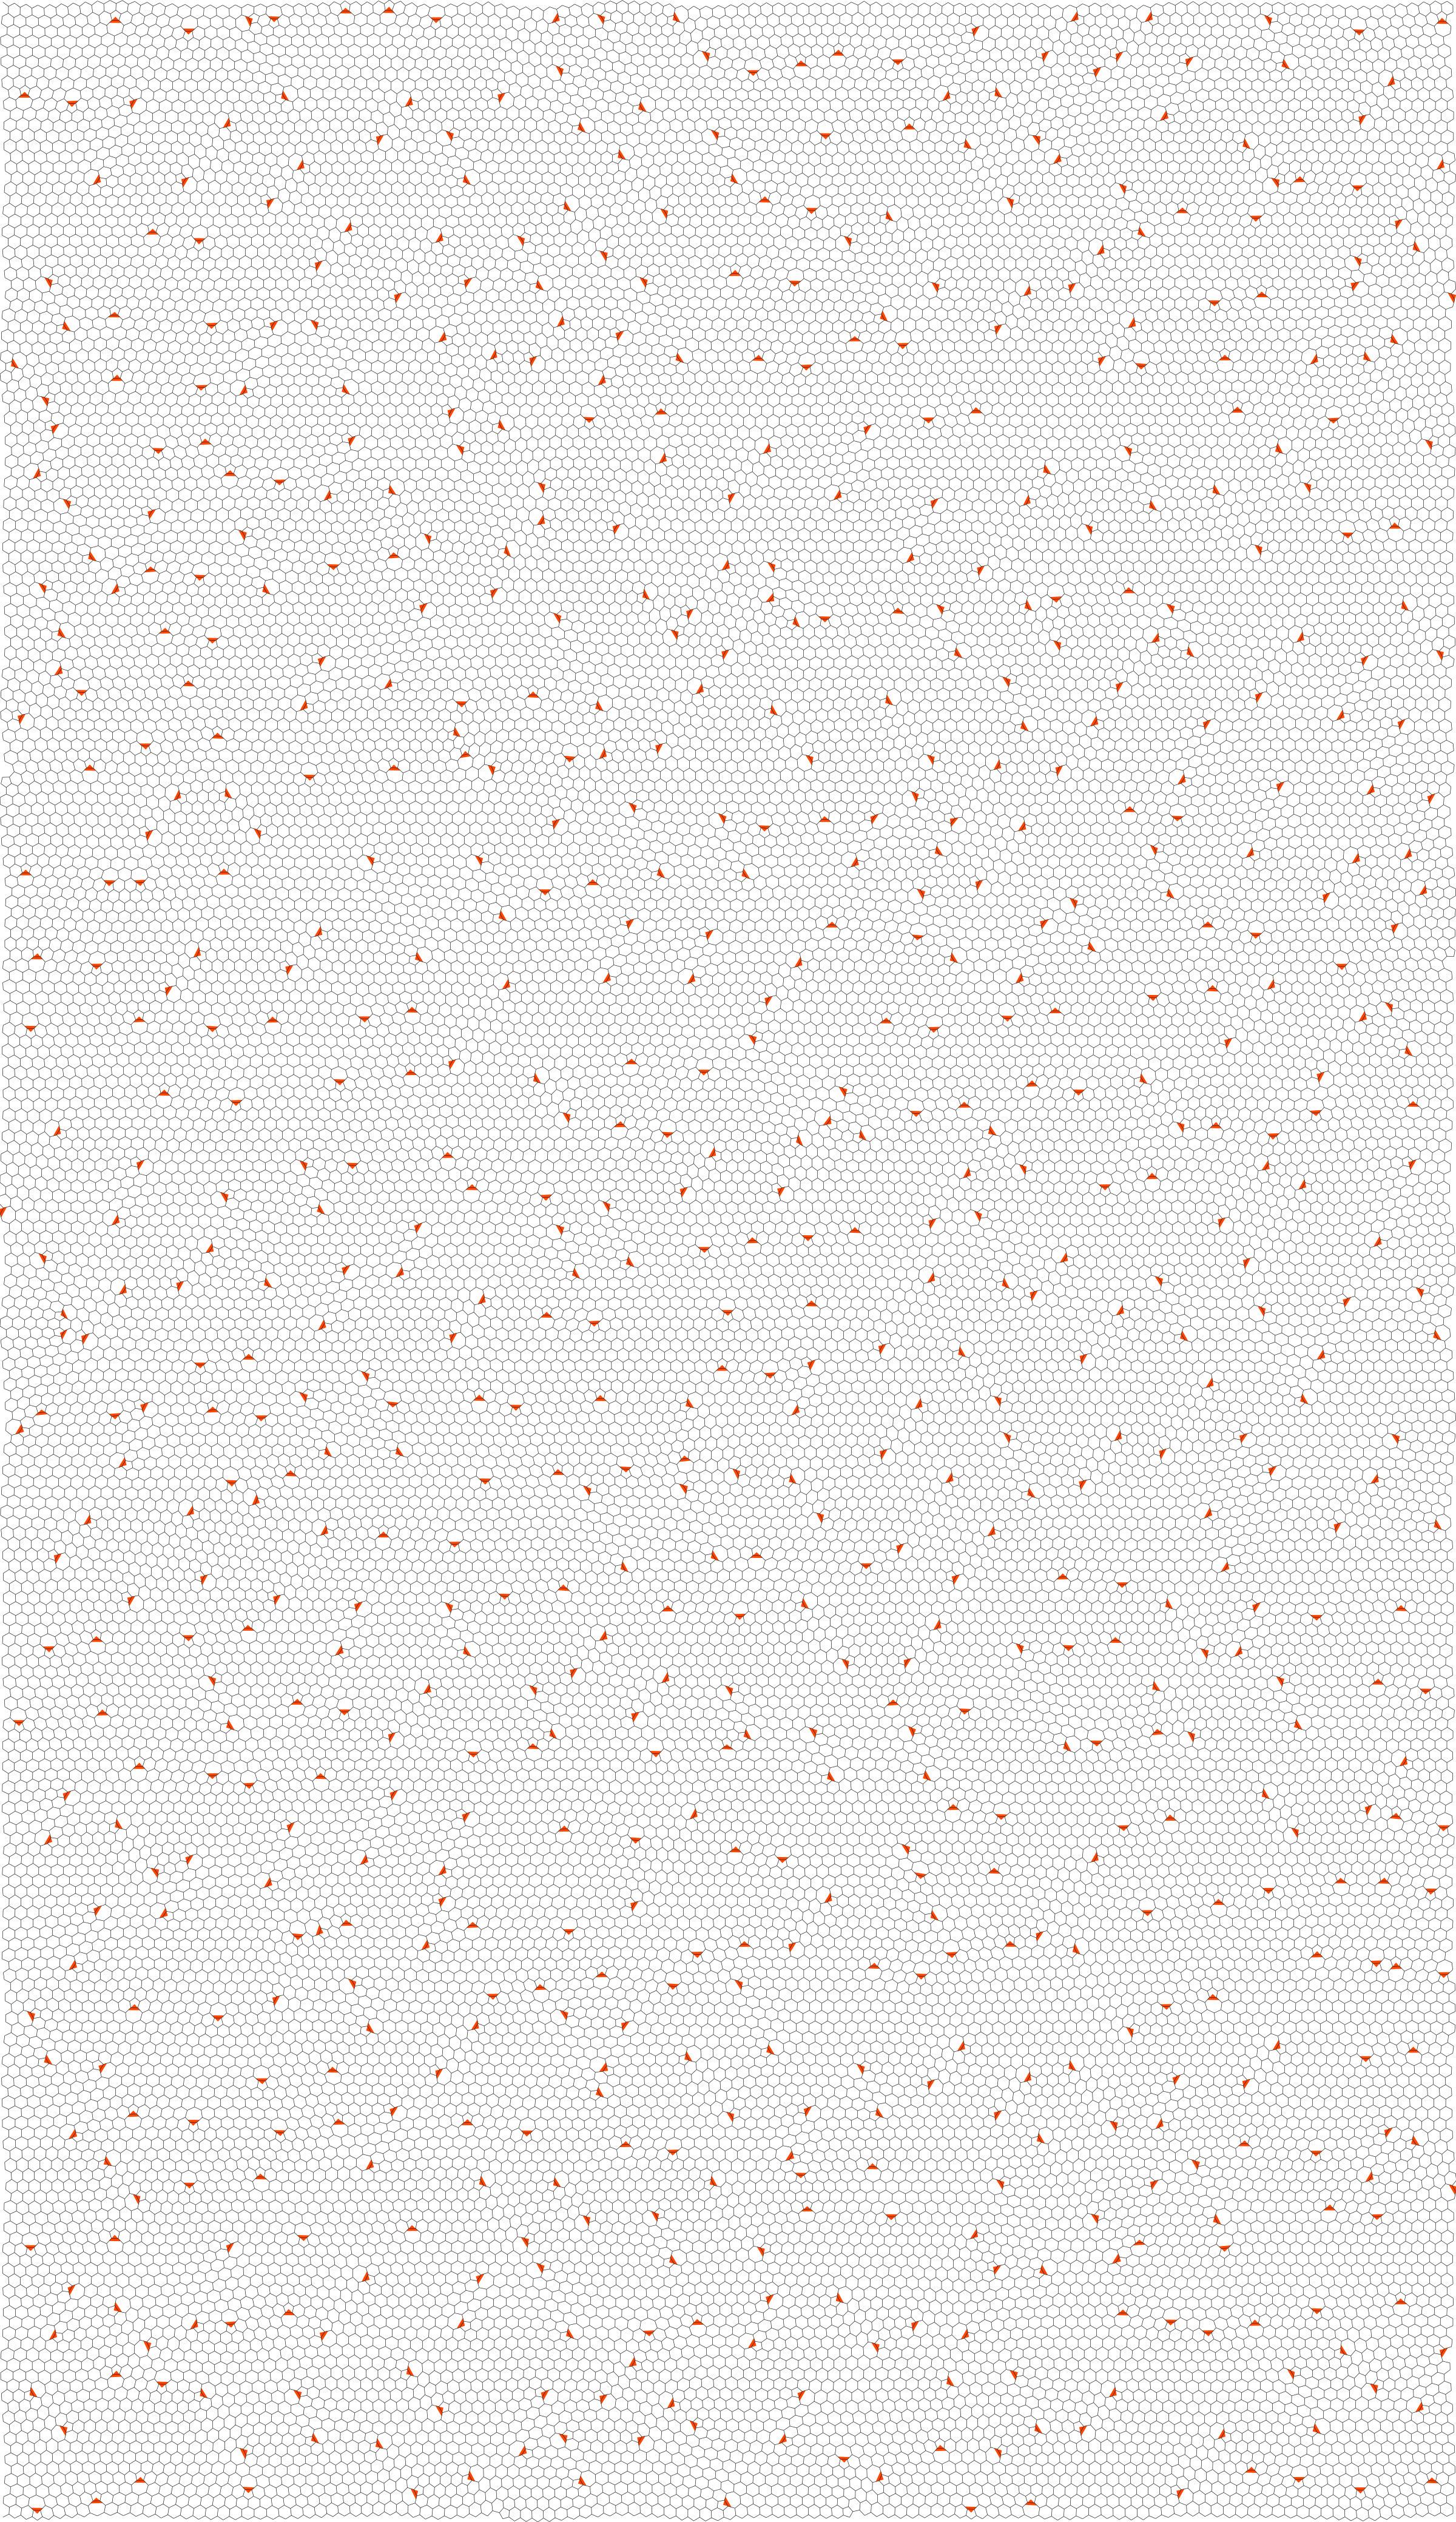

In [27]:
main(1.42, # bond length, Carbon: 1.42
     120, # nx
     240, # ny
     800,  # n_defects, number of defects
     0.5, # k, adjust bond lengths 
     0.2, # ka, move atom to average betw neighbors
     0.1, # da, which atoms to move to average, depending on angles betw bonds
     10,  # n_steps_defect, how many iterations after each defect
     100, # n_steps, number of final iterations
     6, # n_cycles, how many jumps of defects away from each other
     false # print coordinates?
)